In [ ]:
#Импорт библиотек
import numpy as np
import gdal
import matplotlib.pyplot as plt
import ogr
import copy
import shapely.geometry
import geopandas as gpd
from shapely.ops import cascaded_union
import os

In [ ]:
#Открытие изображения, получение данных о нём

#Открытие растра
filename = r'D:\study\MSU\8\RLI\code\Test_raster.tif'
dataset = gdal.Open(filename)

#Получение информации о размере 
cols = dataset.RasterXSize
rows = dataset.RasterYSize

#Получение максимальных и минимальных координат, объединение в экстент
map_info = dataset.GetGeoTransform()
xMin = map_info[0]
yMax = map_info[3]
xMax = xMin + dataset.RasterXSize/map_info[1] 
yMin = yMax + dataset.RasterYSize/map_info[5] 

raster_extent = (xMin,xMax,yMin,yMax)

In [ ]:
#Получение канала изображения
raster_band = dataset.GetRasterBand(1)

#Получение и вывод статистики канала
band_stats = raster_band.GetStatistics(True,True)
print(f'Статистика канала: Минимум= {round(band_stats[0], 2)}, Максимум= {round(band_stats[1], 2)}, Среднее= {round(band_stats[2], 2)}, Стандартное отклонение= {round(band_stats[3], 2)}')

Статистика канала: Минимум= -35.21, Максимум= 24.91, Среднее= -22.84, Стандартное отклонение= 2.01


In [ ]:
#Перевод канала в массив numpy, замена пикселов без значений
ds_array = raster_band.ReadAsArray(0,0,cols,rows).astype(float)
ds_array[ds_array==-3.4028230607370965e+38]=np.nan

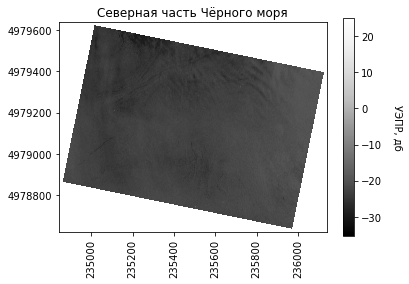

In [ ]:
#Вывод изображения при помощи matplotlib.pyplot
plt.imshow(ds_array, extent = raster_extent); 
cbar = plt.colorbar()
plt.set_cmap('Greys_r') 
cbar.set_label('УЭПР, дб',rotation=270,labelpad=20)
plt.title('Северная часть Чёрного моря') 
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain') 
xticklabels_rot = plt.setp(ax.get_xticklabels(),rotation=90)

Text(0, 0.5, 'Доля пикселов от целого')

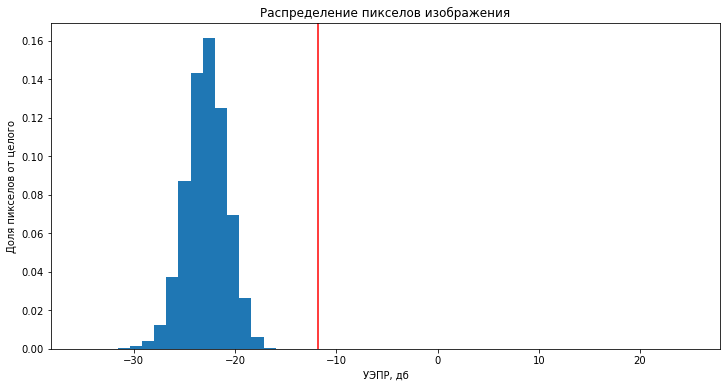

In [ ]:
#Поиск оптимальных значений для выявления кораблей, построение графика 

#Получение массива только со значениями
nonan_array = copy.copy(ds_array)
nonan_array = nonan_array[~np.isnan(ds_array)]

#Построение графика
fig = plt.figure()
fig.set_size_inches(12, 6)
ax = fig.add_subplot(111)
plt.axvline(band_stats[2] + band_stats[3]*5.5, c = 'red') #Построение линии отсечения 
#Построение гистограммы распределения значений 
ax.hist(nonan_array, weights = np.zeros_like(nonan_array)+1./(ds_array.shape[0]*ds_array.shape[1]), bins = 50)
plt.title('Распределение пикселов изображения')
plt.xlabel('УЭПР, дб')
plt.ylabel('Доля пикселов от целого');

In [ ]:
#Реклассификация массива в соответствии с подобранными значениями
array_reclass = copy.copy(ds_array)
array_reclass[np.where(ds_array<=band_stats[2] + band_stats[3]*5.5)] = np.nan
array_reclass[np.where(ds_array>band_stats[2] + band_stats[3]*5.5)] = 1  

In [ ]:
#Создание shape-файла
shp = ogr.GetDriverByName('ESRI Shapefile')
outFile = shp.CreateDataSource(r'D:\study\MSU\8\RLI\code\shape_pol.shp')
dest_srs = ogr.osr.SpatialReference()
dest_srs.ImportFromEPSG(32637)
layer = outFile.CreateLayer('Det', srs = dest_srs)
idField = ogr.FieldDefn('id', ogr.OFTInteger)
layer.CreateField(idField)

0

In [ ]:
#Создание и загрузка промежуточного растра с реклассифицированными значениями
driv = gdal.GetDriverByName('GTiff')
ds_inter = driv.Create(r'D:\study\MSU\8\RLI\code\Raster_int.tif', xsize = dataset.RasterXSize, ysize = dataset.RasterYSize, bands = 1)
ds_inter.SetGeoTransform(dataset.GetGeoTransform())
ds_inter.GetGeoTransform()
ds_inter.SetProjection(dataset.GetProjection())
ds_inter.GetProjection()
outband = ds_inter.GetRasterBand(1)
outband.WriteArray(array_reclass)

#Перевод реклассифицированных значений в shape-файл
gdal.Polygonize(outband, outband, layer, 1, [], callback=None )
outFile.Destroy()

#Удаление промежуточного растра
driv.Delete(r'D:\study\MSU\8\RLI\code\Test2.tif')

3

In [ ]:
gdf = gpd.read_file(r'D:\study\MSU\8\RLI\code\shape_pol.shp') #Загрузка shape-файла с полигонами кораблей как GDF
#Вычисление площадей и сортировка по площади 
gdf['area'] = gdf['geometry'].area 
gdf.sort_values('area', ascending=False, inplace = True)

#Создание GDF, в котором будут храниться объединённые полигоны
gdf_un = gpd.GeoDataFrame(columns = ['geometry'], geometry= 'geometry')
gdf_un.crs = "EPSG:4326"
gdf_un.to_crs(32637, inplace =True)    

#Переменные, необходимые для записи значений и проверки уже записанных полигонов
n = 0
polygons_test = []

#Часть кода, предназначенная для поиска разных полигонов, относящихся к одному кораблю 
for i in gdf['geometry']:
    count = 0
    polygons = []
    for j in gdf['geometry']: #Расчёт расстояний между полигонами, выбор близких друг к другу полигонов 
        if i.centroid.distance(j.centroid) == .0 :
            pass
        elif i.distance(j) < 200: #Расстояние, после которого полигоны считаются принадлежащими к одному кораблю
            if len(polygons) !=0:
                polygons.append(j)
            else:
                polygons.append(i)
                polygons.append(j)
        else:
            pass
    if len (polygons) > 0:
        for poly in polygons:
            if poly in polygons_test:
                count += 1
        if count > 0:
            pass
        else:
            n +=1
            gdf_un.loc[n] = [cascaded_union(polygons)] #Соединение выбранных полигонов в один объект
            for pol in polygons:
                polygons_test.append(pol) #Добавление результата объединения в gdf
    else:
        if i in polygons_test:
            pass
        else:
            n +=1 
            gdf_un.loc[n] = [i]
            polygons_test.append(i) #Добавление объектов, которые не были объединены
        
#Удаление дубликатов
gdf_un.drop_duplicates(inplace = True)

#Поиск центроидов итоговых полигонов, сохранение точечного shape-файла
gdf_fin = gdf_un['geometry'].centroid.to_frame(name = 'geometry')
gdf_fin.to_file(r'D:\study\MSU\8\RLI\code\Fin_shape.shp')